In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
%load_ext autoreload
%autoreload 2

# DeepOF unsupervised pipeline: exploring the behavioral space

##### Tutorial index:
    
* Brief introduction to unsupervised analysis.
* Load your previous project.
* Running an unsupervised analysis with default parameters.
* Understanding the different available models.
* Cluster number selection.
* Temporal and global embeddings.
* Global separation dynamics.
* Exploring cluster enrichment across conditions.
* Exploring cluster dynamics across conditions.
* Interpreting clusters using SHAP.
* Exporting cluster video snippets.

### Brief introduction to unsupervised analysis

### Load your previous project

In [3]:
my_deepof_project = deepof.data.load_project("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial/")

In [4]:
# THIS SHOULD BE THE LAST SECTION OF THE FIRST TUTORIAL!

# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

tt = my_deepof_project.get_coords(center="Center", align="Spine_1")
# ss = my_deepof_project.get_coords(speed=1)

# tt = cc.merge(ss)

tt = tt.preprocess(
    window_size=25,
    window_step=1,
    test_videos=1,
    scale="standard",
    handle_ids="split", # "concat" uses bps from != animals as features, "split"
)

tt = (tt[0][:25000], tt[1][:25000], tt[2][:25000], tt[3][:25000])

In [87]:
# SAME HERE: Last section of the last tutorial should explore tensor and graph preprocessing

from deepof.utils import connect_mouse_topview
import networkx as nx

pp, G, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    animal_id="B",
    center="Center",
    align="Spine_1",
    preprocess=True,
    scale="standard"
)

adj = nx.adjacency_matrix(G).todense()
pp = (pp[0][:25000], pp[1][:25000], pp[2][:25000], pp[3][:25000], pp[4][:25000], pp[5][:25000])

/var/folders/wf/msmt6cvx5xl9t0p2qjd1tn65jtl6l8/T/ipykernel_38051/1053585518.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).todense()


In [88]:
#What happens if we use a two-stage normalization approach?
# 1) Normalize within animals to get rid of body size effects
# 2) Normalize across animals to have similar stats across animals, and get the same clusters regardless of the animal
# ID.

### Running an unsupervised analysis with default parameters

In [89]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    pp,
    adjacency_matrix=adj,
    embedding_model="VaDE",
    epochs=10,
    encoder_type="recurrent",
    n_components=15,
    latent_dim=4,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=128,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
)

2023-01-16 11:02:59.916432: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-01-16 11:02:59.916444: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2023-01-16 11:02:59.916614: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


Epoch 1/10


2023-01-16 11:03:19.456660: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 30s 48ms/step - total_loss: 47.4867 - reconstruction_loss: 45.8371 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0497 - kl_divergence: -2.8479 - kmeans_loss: 1.6613 - number_of_populated_clusters: 13.4462 - confidence_in_selected_cluster: 0.3873
Epoch 2/10
195/195 [==============================] - 9s 45ms/step - total_loss: 44.7026 - reconstruction_loss: 43.5301 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.1497 - kl_divergence: -2.3010 - kmeans_loss: 1.4947 - number_of_populated_clusters: 13.7590 - confidence_in_selected_cluster: 0.3481
Epoch 3/10
  3/195 [..............................] - ETA: 9s - total_loss: 42.3294 - reconstruction_loss: 41.3538 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.2005 - kl_divergence: -2.1836 - kmeans_loss: 1.4060 - number_of_populated_clusters: 14.0000 - confidence_in_selected_cluster: 0.3131 

2023-01-16 11:03:58.146753: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 9s 45ms/step - total_loss: 44.3118 - reconstruction_loss: 43.4362 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.2497 - kl_divergence: -2.1147 - kmeans_loss: 1.3996 - number_of_populated_clusters: 14.1692 - confidence_in_selected_cluster: 0.3145
Epoch 4/10
195/195 [==============================] - 9s 45ms/step - total_loss: 44.0155 - reconstruction_loss: 43.3642 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.3497 - kl_divergence: -2.0908 - kmeans_loss: 1.3798 - number_of_populated_clusters: 14.2256 - confidence_in_selected_cluster: 0.3083
Epoch 5/10
195/195 [==============================] - 9s 45ms/step - total_loss: 43.6366 - reconstruction_loss: 43.1536 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.4497 - kl_divergence: -2.1084 - kmeans_loss: 1.4280 - number_of_populated_clusters: 14.1026 - confidence_in_selected_cluster: 0.3276
Epoch 6/10
195/195 [======================

2023-01-16 11:04:33.911898: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 9s 45ms/step - total_loss: 42.3187 - reconstruction_loss: 42.1838 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.6497 - kl_divergence: -2.3169 - kmeans_loss: 1.6204 - number_of_populated_clusters: 13.7692 - confidence_in_selected_cluster: 0.3960
Epoch 8/10
195/195 [==============================] - 9s 46ms/step - total_loss: 41.7866 - reconstruction_loss: 41.9477 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.7497 - kl_divergence: -2.6777 - kmeans_loss: 1.7775 - number_of_populated_clusters: 13.7077 - confidence_in_selected_cluster: 0.4355
Epoch 9/10
195/195 [==============================] - 9s 45ms/step - total_loss: 41.2827 - reconstruction_loss: 41.8038 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.8497 - kl_divergence: -3.0523 - kmeans_loss: 1.9228 - number_of_populated_clusters: 13.5436 - confidence_in_selected_cluster: 0.4645
Epoch 10/10
195/195 [=====================

2023-01-16 11:05:12.859898: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


  1/195 [..............................] - ETA: 21:00 - total_loss: 48.7155 - reconstruction_loss: 44.5267 - clustering_loss: -0.9817 - prior_loss: 2.7080 - kl_weight: 0.0000e+00 - kl_divergence: -3.4072 - kmeans_loss: 2.1987 - number_of_populated_clusters: 7.0000 - confidence_in_selected_cluster: 0.9882

2023-01-16 11:05:19.446870: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-01-16 11:05:19.446881: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  4/195 [..............................] - ETA: 8:56 - total_loss: 46.9946 - reconstruction_loss: 42.8992 - clustering_loss: -0.9849 - prior_loss: 2.7080 - kl_weight: 7.6923e-04 - kl_divergence: -3.4688 - kmeans_loss: 2.1064 - number_of_populated_clusters: 6.2500 - confidence_in_selected_cluster: 0.9890 

2023-01-16 11:05:27.744144: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-16 11:05:27.745865: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2023-01-16 11:05:27.747041: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_VaDE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=4_k=15_20230116-110259/plugins/profile/2023_01_16_11_05_27

2023-01-16 11:05:27.748631: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_VaDE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=4_k=15_20230116-110259/plugins/profile/2023_01_16_11_05_27/MC-C9791E.local.trace.json.gz
2023-01-16 11:05:27.749183: I tensorflow/core/profiler

195/195 [==============================] - 25s 93ms/step - total_loss: 45.2556 - reconstruction_loss: 41.5753 - clustering_loss: -0.9812 - prior_loss: 2.7080 - kl_weight: 0.0497 - kl_divergence: -3.0401 - kmeans_loss: 1.9510 - number_of_populated_clusters: 5.9231 - confidence_in_selected_cluster: 0.9869 - lr: 0.0010
Epoch 2/10
195/195 [==============================] - ETA: 0s - total_loss: 44.5856 - reconstruction_loss: 41.4826 - clustering_loss: -0.9781 - prior_loss: 2.7080 - kl_weight: 0.1497 - kl_divergence: -2.3281 - kmeans_loss: 1.7018 - number_of_populated_clusters: 6.3897 - confidence_in_selected_cluster: 0.9847

2023-01-16 11:05:46.814781: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 9s 48ms/step - total_loss: 44.5856 - reconstruction_loss: 41.4826 - clustering_loss: -0.9781 - prior_loss: 2.7080 - kl_weight: 0.1497 - kl_divergence: -2.3281 - kmeans_loss: 1.7018 - number_of_populated_clusters: 6.3897 - confidence_in_selected_cluster: 0.9847 - lr: 0.0010
Epoch 3/10
195/195 [==============================] - 9s 48ms/step - total_loss: 44.2708 - reconstruction_loss: 41.4343 - clustering_loss: -0.9781 - prior_loss: 2.7080 - kl_weight: 0.2497 - kl_divergence: -2.1332 - kmeans_loss: 1.6370 - number_of_populated_clusters: 6.2974 - confidence_in_selected_cluster: 0.9847 - lr: 0.0010
Epoch 4/10
195/195 [==============================] - 9s 48ms/step - total_loss: 43.9899 - reconstruction_loss: 41.3496 - clustering_loss: -0.9814 - prior_loss: 2.7080 - kl_weight: 0.3497 - kl_divergence: -2.0984 - kmeans_loss: 1.6466 - number_of_populated_clusters: 6.0564 - confidence_in_selected_cluster: 0.9870 - lr: 0.0010
Epoch 5/10
195/195 [=======

2023-01-16 11:06:24.633075: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 9s 47ms/step - total_loss: 43.3994 - reconstruction_loss: 41.1651 - clustering_loss: -0.9838 - prior_loss: 2.7080 - kl_weight: 0.5497 - kl_divergence: -2.2171 - kmeans_loss: 1.7235 - number_of_populated_clusters: 5.5179 - confidence_in_selected_cluster: 0.9887 - lr: 0.0010
Epoch 7/10
195/195 [==============================] - 10s 49ms/step - total_loss: 43.1195 - reconstruction_loss: 41.1426 - clustering_loss: -0.9855 - prior_loss: 2.7080 - kl_weight: 0.6497 - kl_divergence: -2.5179 - kmeans_loss: 1.8501 - number_of_populated_clusters: 5.1231 - confidence_in_selected_cluster: 0.9898 - lr: 0.0010
Epoch 8/10
195/195 [==============================] - 10s 49ms/step - total_loss: 42.7752 - reconstruction_loss: 41.0945 - clustering_loss: -0.9871 - prior_loss: 2.7080 - kl_weight: 0.7497 - kl_divergence: -2.8130 - kmeans_loss: 1.9708 - number_of_populated_clusters: 4.8718 - confidence_in_selected_cluster: 0.9910 - lr: 0.0010
Epoch 9/10
195/195 [=====

2023-01-16 11:07:03.231696: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 10s 49ms/step - total_loss: 42.0301 - reconstruction_loss: 41.0486 - clustering_loss: -0.9903 - prior_loss: 2.7080 - kl_weight: 0.9497 - kl_divergence: -3.4756 - kmeans_loss: 2.2888 - number_of_populated_clusters: 4.3949 - confidence_in_selected_cluster: 0.9933 - lr: 0.0010
CPU times: user 10min 29s, sys: 1min 41s, total: 12min 11s
Wall time: 4min 6s


### Understanding the different available models

In [90]:
cons.vade.summary()

Model: "VaDE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 25, 33)]     0           []                               
                                                                                                  
 encoder_edge_features (InputLa  [(None, 25, 11)]    0           []                               
 yer)                                                                                             
                                                                                                  
 recurrent_encoder (Functional)  (None, 4)           3484        ['input_53[0][0]',               
                                                                  'encoder_edge_features[0][0]']  
                                                                                               

### Cluster number selection

### Visualizing temporal and global embeddings

In [91]:
my_deepof_project.get_exp_conditions

{'20191204_Day2_SI_JB08_Test_56': 'Stressed',
 '20191204_Day2_SI_JB08_Test_61': 'Stressed',
 '20191204_Day2_SI_JB08_Test_62': 'Stressed',
 '20191204_Day2_SI_JB08_Test_54': 'Nonstressed',
 '20191204_Day2_SI_JB08_Test_63': 'Nonstressed',
 '20191204_Day2_SI_JB08_Test_64': 'Nonstressed'}

In [92]:
embeddings = {}
soft_counts = {}

for key in my_deepof_project.get_exp_conditions.keys():
    
    print(key)
    
    dd, _, _, _ = my_deepof_project.get_graph_dataset(
        animal_id="B",
        precomputed_tab_dict=to_preprocess.filter_videos([key]),
        preprocess=True,
        scale="standard",
        shuffle=False,
        pretrained_scaler=global_scaler,
    )

    dd = (dd[0], dd[1], dd[2], dd[3], dd[4], dd[5])

#     dd = my_deepof_project.get_coords(
#         center="Center", align="Spine_1"
#     ).filter_id("B").filter_videos([key]).preprocess(
#         shuffle=False,
#         test_videos=0,
#     )
#     dd = [dd[0], dd[0]]
    
    embeddings[key] = cons.encoder([dd[0], dd[1]])
    soft_counts[key] = cons.grouper([dd[0], dd[1]])

20191204_Day2_SI_JB08_Test_56
20191204_Day2_SI_JB08_Test_61
20191204_Day2_SI_JB08_Test_62
20191204_Day2_SI_JB08_Test_54
20191204_Day2_SI_JB08_Test_63
20191204_Day2_SI_JB08_Test_64


In [93]:
set(soft_counts['20191204_Day2_SI_JB08_Test_56'].numpy().argmax(axis=1))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [94]:
# TEMPORARY SOLUTION: Load precomputed embeddings. 
# Solve this later by defaulting embedding saving to a known directory within the project path.

# import pickle

# emb="TCN"
# run=2
# with open(f"../../../Results/CSDS_embeddings/deepof_unsupervised_VaDE_encoder_{emb}_encodings_input=graph_k=25_latdim=8_changepoints_False_kmeans_loss=0.0_run={run}.pkl", "rb") as handle:
#     embeddings, soft_counts, breaks = pickle.load(handle)

In [95]:
def get_patched_breaks(key):
        
    tt, g, prep, _ = my_deepof_project.get_graph_dataset(center="Center", align="Spine_1", animal_id="B", shuffle=False)
    tt = my_deepof_project.get_graph_dataset(
        precomputed_tab_dict=prep.filter_videos([key]),
        animal_id="B",
        window_size=25,
        window_step=1,
        shuffle=False,
        automatic_changepoints=False,
        scale="standard",
        test_videos=0,
    )[0]

    return (~np.all(tt[0] == 0, axis=2)).sum(axis=1)

In [96]:
import numpy as np
breaks = {
    key: get_patched_breaks(key) for key in my_deepof_project.get_exp_conditions.keys()
}

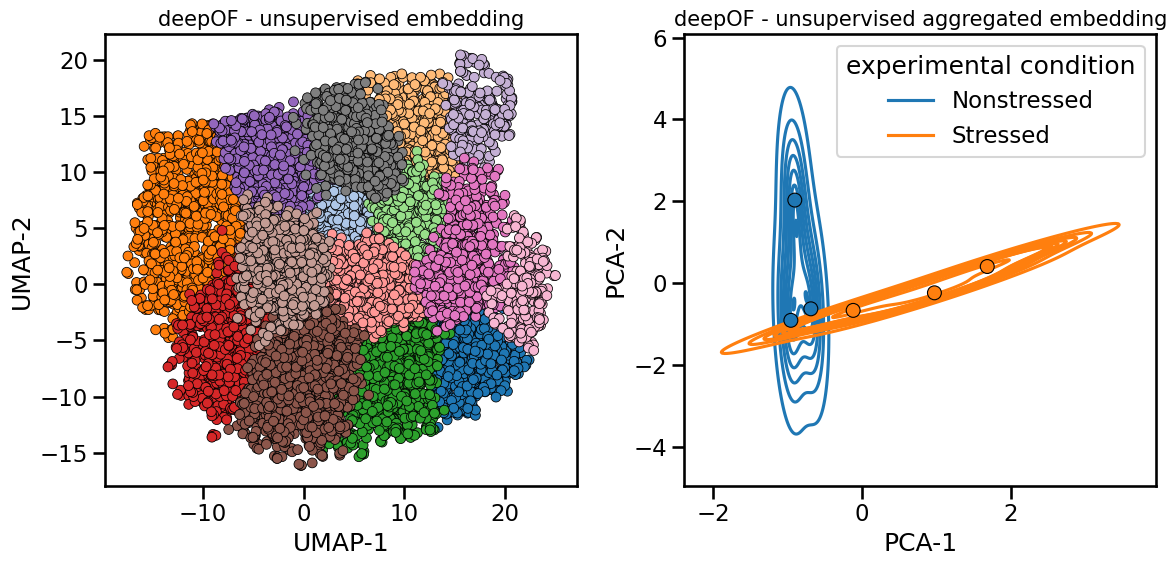

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_embeddings(
    my_deepof_project, 
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments=False,
    ax=ax1,
    save=False, # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments="median",
    ax=ax2,
    save=False, # Set to True, or give a custom name, to save the plot,
)

plt.tight_layout()
plt.show()

In [103]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
    animal_id="B",
    cluster_assignments=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=150,
    selected_cluster=4,
    dpi=60,
    #center="Center",
    #align="Spine_1",
    #embedding=[emb_B, emb_W],
)

html = display.HTML(video)
display.display(html)
plt.close()

In [101]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
    animal_id="B",
    cluster_assignments=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=150,
    selected_cluster=4,
    dpi=60,
    #center="Center",
    #align="Spine_1",
    #embedding=[emb_B, emb_W],
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
    cluster_assignments=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=250,
    selected_cluster=4,
    dpi=60,
    #center="Center",
    #align="Spine_1",
    #embedding=[emb_B, emb_W],
)

html = display.HTML(video)
display.display(html)
plt.close()

#TODO: Correct for misalignment. The way this is implemented, 
#      makes the last data point the representative of the sequence, not the middle one.

### Global separation dynamics

### Exploring cluster enrichment across conditions

### Exploring cluster dynamics across conditions

In [ ]:
fig = plt.figure(figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_gantt(
    my_deepof_project,
    soft_counts=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
)

### Interpreting clusters using SHAP

### Exporting cluster video snippets

In [ ]:
# TODO: they should be saved to a directory that makes sense!.

In [ ]:
import pandas as pd
import os

files = [i for i in os.listdir("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Tables/")]

for f in files:
    cur = pd.read_hdf("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Tables/" + f)
    
    cur.to_csv("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Tables/" + f[:-2] + "csv")

In [ ]:
emb = cons.encoder([pp[0][:25000], pp[1][:25000]])
cls = cons.quantizer([pp[0][:25000], pp[1][:25000]])

In [ ]:
import umap
umap = umap.UMAP(
    n_components=2, 
    n_neighbors=250,
    min_dist=1.0,
).fit_transform(emb.numpy())
# umap = emb.numpy()

In [ ]:
from collections import Counter

Counter(cls.numpy().argmax(axis=1))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#tt = GaussianMixture(n_components=5, covariance_type="diag", reg_covar=1e-04).fit(emb.numpy())
#means = tt.means_
#means = cons.get_gmm_params['means'].numpy()

sns.scatterplot(x=umap[:, 0], y=umap[:, 1], hue=cls.numpy().argmax(axis=1), palette="tab20")
# means = cons.get_layer("grouper").get_layer("gaussian_mixture_latent").c_mu.numpy()
# sns.scatterplot(x=means[:,0], y=means[:,1], s=250, c="black")

plt.title("DeepOF embeddings")

# plt.legend("")
plt.show()

In [ ]:
cons.get_gmm_params['weights'].numpy().sum()

In [ ]:
tt = np.split(np.concatenate(tt), np.cumsum([i.shape[0] for k,i in vqvae_solution[0].items() if k in list(cc.keys())]))

for i in tt:
    print(i.shape)
    print(np.max(np.abs(i.mean(axis=0))))
    print(np.mean(np.abs(i.std(axis=0))))


In [ ]:
# import pickle
# import numpy as np
# with open("../train_models/deepof_unsupervised_VQVAE_encodings_input=coords_k=100_latdim=8_kmeans_loss=0.0_run=1.pkl", "rb") as handle:
#     vqvae_solution = pickle.load(handle)

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from deepof.post_hoc import get_transitions
# from hmmlearn.hmm import GaussianHMM
# from tqdm import tqdm_notebook as tqdm


# def merge_and_smooth_clusters(
#     n_clusters, centroids, embedding, concat_embedding, cluster_assignments
# ):
#     """Merges the current clusters using a hierarchical agglomerative approach, and smoothens using a Gaussian HMM.

#     Args:
#         n_clusters (int): number of clusters to report.
#         centroids (np.ndarray): precomputed means per cluster.
#         embedding (tabdict): original deepof.TableDict object containing unsupervised embeddings.
#         concat_embedding (np.ndarray): concatenated list of embeddings per animal in the dataset.
#         cluster_assignments (tabdict): original deepof.TableDict object containing cluster assignments.

#     Returns:
#         new_soft_assignments (np.ndarray): concatenated postprocessed assignments for all animals in the dataset.
#     """

#     # Merge clusters ussing a hierarchical agglomerative approach
#     new_hard_assignments = AgglomerativeClustering(
#         n_clusters=n_clusters, compute_distances=True
#     ).fit_predict(centroids)
#     cluster_predictor = LinearDiscriminantAnalysis().fit(
#         centroids, new_hard_assignments
#     )
#     centroids = cluster_predictor.means_
#     new_soft_assignments = cluster_predictor.predict_proba(concat_embedding)

#     # Rebuild the soft assignments dictionary per experimental animal
#     new_soft_assignments = np.split(
#         new_soft_assignments,
#         np.cumsum([i.shape[0] for i in embedding.values()]),
#     )
#     new_soft_assignments = {
#         key: val for key, val in zip(cluster_assignments.keys(), new_soft_assignments)
#     }

#     # Smooth assignments across time using a Gaussian HMM on the embeddings, with priors based on the clustering results
#     for key, val in tqdm(new_soft_assignments.items()):

#         hmm = GaussianHMM(
#             startprob_prior=np.unique(val.argmax(axis=1), return_counts=True)[1],
#             transmat_prior=get_transitions(val.argmax(axis=1), n_states=n_clusters) + 10,
#             means_prior=centroids,
#             n_components=n_clusters,
#             covariance_type="diag",
#             n_iter=100,
#             tol=0.0001,
#         )
        
#         hmm.fit(embedding[key].numpy())
#         new_soft_assignments[key] = hmm.predict_proba(embedding[key].numpy())

#     return new_soft_assignments


# def cluster_postprocessing(embedding, cluster_assignments, n_clusters="auto"):
#     """Merges clusters using a hierarchical approach.

#     Args:
#         embedding (list): list of embeddings per animal in the dataset.
#         cluster_assignments (list): list of cluster assignments per animal in the dataset.
#         n_clusters (int): number of clusters to report.

#     Returns:
#         new_soft_assignments (list): list of new (merged) cluster assignments.

#     """
#     # Concatenate embeddings and cluster assignments in to unique np.ndarray objects
#     concat_embedding = np.concatenate([tensor.numpy() for tensor in embedding.values()])
#     hard_assignments = np.concatenate(
#         [tensor.numpy().argmax(axis=1) for tensor in cluster_assignments.values()]
#     )

#     assert concat_embedding.shape[0] == hard_assignments.shape[0]

#     # Get cluster centroids from the concatenated embeddings
#     centroids = []
#     for cluster in range(np.max(hard_assignments)):
#         centroid = concat_embedding[hard_assignments == cluster]
#         if len(centroid) == 0:
#             continue
#         centroid = np.mean(centroid, axis=0)
#         centroids.append(centroid)

#     centroids = np.stack(centroids)

#     # Merge centroids using a hierarchical approach with the given resolution, and soft-assign instances to clusters
#     if isinstance(n_clusters, int):
#         new_soft_assignments = merge_and_smooth_clusters(
#             n_clusters, centroids, embedding, concat_embedding, cluster_assignments
#         )

#     else:
#         raise NotImplementedError

#     return new_soft_assignments

In [ ]:
# from hmmlearn.hmm import GaussianHMM

# new_ass = cluster_postprocessing(
#     vqvae_solution[0], 
#     vqvae_solution[1],
#     n_clusters=12
# )
# hcc = new_ass['20191203_Day1_SI_JB08_Test_54'].argmax(axis=1)

In [ ]:
# import umap

# # Cluster on the original embedding space
# new_emb = umap.UMAP(n_components=2, n_neighbors=75).fit_transform(vqvae_solution[0]['20191203_Day1_SI_JB08_Test_54'])

# sns.scatterplot(x=new_emb[:, 0], y=new_emb[:, 1], hue=hcc, palette="tab20")

# plt.show()

In [ ]:
# # How prevalent are these clusters?
# from collections import Counter
# print(Counter(hcc))

# new_ass = hcc

In [ ]:
# # How often does the model change clusters?
# from collections import defaultdict

# lengths = defaultdict(list)
# cur = 0
# for i in range(1, len(new_ass)):
#     if new_ass[i-1] == new_ass[i]:
#         cur += 1
#     else:
#         lengths[new_ass[i-1]].append(cur)
#         cur = 1

# {key:np.mean(val) for key, val in lengths.items()}

In [ ]:
# import pandas as pd

# # Duration histograms per cluster
# lengths_df = pd.DataFrame([lengths]).melt().explode("value").astype(int)
# sns.violinplot(data=lengths_df, x="variable", y="value")

# plt.axhline(25, linestyle="--", color="black")
        
# plt.show()